In [1]:
# Set project root
import os
import sys

# Manually set the path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import json

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.geometry import recover_pose_from_homography
from src.measurement_data import load_measurements_from_yaml
from src.plotting import draw_3d_axes

## Function definition

In [3]:
def load_calibration_json(filename):
    with open(filename) as f:
        data = json.load(f)

    camera_matrix = np.array(data['camera_matrix'])
    dist_coeff = np.array(data['dist_coeff'])
    image_size = tuple(data['image_size'])

    return camera_matrix, dist_coeff, image_size

In [4]:
def detect_template_regions(template, images, image_paths, max_matches=50, K=None, dist_coeff=None):
    """
    Detects template matches in a list of images using SIFT and homography estimation.
    Undistortion is applied only after matching, for accurate geometric interpretation.

    Parameters:
        template (np.ndarray): Grayscale template image.
        images (List[np.ndarray]): List of grayscale target images.
        image_paths (List[str]): Paths to the images (for display purposes).
        max_matches (int): Max number of matches to draw and consider.
        K (np.ndarray or None): Camera intrinsic matrix (3x3), if known.
        dist_coeff (np.ndarray or None): Distortion coefficients (1D or 5x1), if known.

    Returns:
        List[Dict]: Detection info per image (homography, match mask, etc.).
    """
    sift = cv2.SIFT_create()
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    print("[INFO] Extracting SIFT keypoints...")
    keypoints_template, descriptors_template = sift.detectAndCompute(template, None)
    print(f" - Template: {len(keypoints_template)} keypoints")

    visual_results = []
    return_data = []

    for idx, (image, path) in enumerate(zip(images, image_paths)):
        keypoints_image, descriptors_image = sift.detectAndCompute(image, None)
        image_name = path.split('/')[-1]
        print(f" - {image_name}: {len(keypoints_image)} keypoints")

        matches = bf.match(descriptors_template, descriptors_image)
        matches = sorted(matches, key=lambda x: x.distance)[:max_matches]
        print(f"\n[INFO] {len(matches)} raw matches found")

        if len(matches) >= 4:
            M, mask = compute_homography(matches, keypoints_template, keypoints_image)

            if M is not None:
                inliers = int(np.sum(mask))
                print(f"[INFO] Homography computed with {inliers} inliers")

                # Apply distortion correction to the projected corners if calibration is available
                image_out = draw_rectangle(image, M, template.shape[:2], K, dist_coeff)
                image_out = draw_inliers(image_out, matches, mask, keypoints_image)
            else:
                print("[ERROR] Homography computation failed")
                image_out = image.copy()
                mask = None
        else:
            print("[WARNING] Not enough matches to compute homography")
            M = None
            mask = None
            image_out = image.copy()
        print()

        visual_results.append((image_name, image_out))
        return_data.append({
            'image': image_name,
            'homography': M,
            'mask': mask
        })

    print("\n📦 Plotting detected regions...\n")
    fig, axes = plt.subplots(1, len(visual_results), figsize=(5 * len(visual_results), 5))
    if len(visual_results) == 1:
        axes = [axes]
    for ax, (name, image_out) in zip(axes, visual_results):
        ax.imshow(image_out, cmap='gray')
        ax.set_title(name)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    return return_data

def compute_homography(matches, keypoints1, keypoints2):
    """
    Computes a homography using matched keypoints.

    Parameters:
        matches (List[cv2.DMatch]): List of matched keypoints.
        keypoints1 (List[cv2.KeyPoint]): Keypoints from the template.
        keypoints2 (List[cv2.KeyPoint]): Keypoints from the image.

    Returns:
        (np.ndarray, np.ndarray): Homography matrix and inlier mask.
    """
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    return M, mask

def draw_rectangle(image, M, template_shape, K=None, dist_coeff=None):
    """
    Draws a rectangle on the image corresponding to the projected template.

    Parameters:
        image (np.ndarray): Target image.
        M (np.ndarray): Homography from template to image.
        template_shape (Tuple[int, int]): Shape of the template (height, width).
        K (np.ndarray or None): Camera intrinsic matrix.
        dist_coeff (np.ndarray or None): Distortion coefficients.

    Returns:
        np.ndarray: Image with projected rectangle drawn.
    """
    h, w = template_shape
    template_corners = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)

    projected_corners = cv2.perspectiveTransform(template_corners, M)

    if K is not None and dist_coeff is not None:
        # Projected corners are in distorted space – undistort them to metric space
        projected_corners = cv2.undistortPoints(projected_corners, K, dist_coeff, P=K)

    return cv2.polylines(image.copy(), [np.int32(projected_corners)], isClosed=True, color=(255, 0, 0), thickness=3)

def draw_inliers(image, matches, mask, keypoints):
    """
    Draws circles around inlier matches on the image.

    Parameters:
        image (np.ndarray): Input image.
        matches (List[cv2.DMatch]): Matched keypoints.
        mask (np.ndarray): Inlier mask from RANSAC.
        keypoints (List[cv2.KeyPoint]): Image keypoints.

    Returns:
        np.ndarray: Annotated image.
    """
    inliers = [m for i, m in enumerate(matches) if mask[i]]
    for m in inliers:
        pt = keypoints[m.trainIdx].pt
        cv2.circle(image, (int(pt[0]), int(pt[1])), 5, (0, 255, 0), -1)
    return image

In [5]:
def compute_distance_grid_new(R, t_unscaled, width, height, template_real_length, template_pixel_length):
    """
    Compute the distances from the camera center to a 3x3 grid of real-world points on a planar template.

    Parameters:
        R (np.ndarray): 3x3 rotation matrix from template to camera
        t_unscaled (np.ndarray): 3x1 translation vector (unscaled, from homography decomposition)
        width (float): Template width in real-world units (e.g., mm)
        height (float): Template height in real-world units (e.g., mm)

    Returns:
        np.ndarray: 3x3 array of distances from the camera to each of the 9 grid points
    """
    # Define two points in the template's local coordinate system (known real-world distance between them)
    p_world1 = np.array([[0], [0], [0]])          # Top-left corner
    p_world2 = np.array([[width], [0], [0]])      # Top-right corner

    # Transform both into the camera coordinate system using unscaled t
    p_cam1 = R @ p_world1 + t_unscaled
    p_cam2 = R @ p_world2 + t_unscaled

    # Compute the distance between the transformed points
    cam_distance = np.linalg.norm(p_cam2 - p_cam1)

    # Compute scale factor to align camera space with real-world distance
    real_distance = width
    scale = real_distance / cam_distance

    # Compute the scale factor based on the template's real-world length and pixel length
    scale_factor = template_real_length / template_pixel_length

    # Apply scale to the translation vector
    t_scaled = t_unscaled * scale

    print(f"Scale: {scale}")
    print(f"Scale factor: {scale_factor}")
    print(f"Original ||t||: {np.linalg.norm(t_unscaled)}")
    print(f"Scaled ||t||: {np.linalg.norm(t_scaled)}")

    # 3x3 grid: corners, midpoints, center
    x_vals = [0, width / 2, width]
    y_vals = [0, height / 2, height]

    distances = np.zeros((3, 3))

    for i, y in enumerate(y_vals):
        for j, x in enumerate(x_vals):
            pt_world = np.array([[x], [y], [0]])  # in template frame
            pt_cam = R @ pt_world + t_scaled      # in camera frame
            dist = np.linalg.norm(pt_cam)
            distances[i, j] = dist * scale_factor

    return distances

## Analysis

In [6]:
# Load measurement data
data = load_measurements_from_yaml("../assets/measurements.yaml")

In [7]:
# Load scene and template
scene = data.get_scene("S5")
template = data.get_template("T0")

scene_path = os.path.join(project_root, scene.path)
template_path = os.path.join(project_root, template.path)

scene_image = cv2.cvtColor(cv2.imread(scene_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
template_image = cv2.cvtColor(cv2.imread(template_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

print(f"{scene}\n")
print(template)

[S5] Both templates - Another Angle v2
* path: assets/images/scene_05.jpg
* distances:
	Camera <-> T0 = 325.0
	Camera <-> T1 = 260.0
	T0 <-> T1 = 150.0

[T0] DA Card
* path:   assets/templates/template_00.jpg
* (w, h): 85.0×55.0


In [8]:
# Load camera calibration data
K, dist_coeff, image_size = load_calibration_json('../assets/camera_calibration.json')

print(f"Camera matrix:\n{K}\n")
print(f"Distortion coefficients:{dist_coeff}\n")
print(f"Image size (w, h): {image_size}")

Camera matrix:
[[894.67311331   0.         485.2289589 ]
 [  0.         896.1589482  633.03618469]
 [  0.           0.           1.        ]]

Distortion coefficients:[[ 0.0959633   0.12784815  0.00436388  0.00226419 -2.07290104]]

Image size (w, h): (960, 1280)


[INFO] Extracting SIFT keypoints...
 - Template: 616 keypoints
 - scene_05.jpg: 1947 keypoints

[INFO] 161 raw matches found
[INFO] Homography computed with 49 inliers


📦 Plotting detected regions...



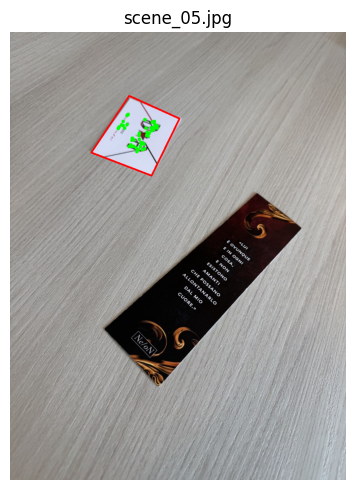

In [9]:
# Compute homography and draw rectangle
results = detect_template_regions(template_image, [scene_image], [scene_path], max_matches=500, K=K, dist_coeff=dist_coeff)

In [10]:
H = results[0]['homography']
mask = results[0]['mask']

In [11]:
# Recover the pose using the homography matrix and camera intrinsics
R, t = recover_pose_from_homography(H, K)

In [12]:
R, t

(array([[-0.24951506, -0.93491036, -0.25235858],
        [ 0.77091897, -0.34948212,  0.53249055],
        [-0.58602574, -0.06168361,  0.80794119]]),
 array([-3.32036974e-01, -1.38626439e+03,  3.21168475e+03]))

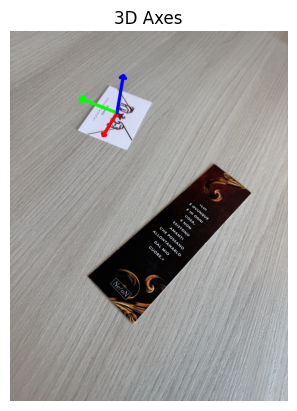

In [13]:
t_shape = template_image.shape[:2]

# Draw 3D axes
img = draw_3d_axes(scene_image, R, t, K, template_shape=t_shape)

# Plot the image with 3D axes
plt.show()
plt.imshow(img)
plt.title("3D Axes")
plt.axis('off')
plt.show()

In [14]:
# Width and height in real-world units (e.g., mm)
real_w = template.width
real_h = template.height
width = t_shape[1]
height = t_shape[0]


dist_grid = compute_distance_grid_new(
    R=R,
    t_unscaled=t,
    width=real_w,
    height=real_h,
    template_real_length=real_h,
    template_pixel_length=height
)
print(np.round(dist_grid, 2))

Scale: 0.5773502691896251
Scale factor: 0.0954861111111111
Original ||t||: 3498.092053299579
Scaled ||t||: 2019.6243886226002
[[334.02 334.01 334.16]
 [332.98 332.98 333.12]
 [332.01 332.   332.15]]


In [15]:
unit = data.unit
from_id = 'Camera'
to_id = template.id

scale_factor = template.width / t_shape[1]
distance_pred = dist_grid[1, 1]
distance_true = scene.get_distance(from_id, to_id).distance
error = np.abs(distance_pred - distance_true)
error_perc = (error / distance_true) * 100

print(f"Scale factor: {scale_factor} {unit}/pixel")
print(f"Predicted distance: {distance_pred:.2f} {unit}")
print(f"True distance: {distance_true} {unit}")
print(f"Error: {error:.2f} {unit} - {error_perc:.2f}%")

Scale factor: 0.09615384615384616 mm/pixel
Predicted distance: 332.98 mm
True distance: 325.0 mm
Error: 7.98 mm - 2.46%


In [16]:
# Create results directory if it doesn't exist
results_path = os.path.join(project_root, "results")
os.makedirs(results_path, exist_ok=True)

# Define the CSV path
csv_path = os.path.join(results_path, "measurement_results_v2.csv")

# Load or initialize the DataFrame
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
else:
    df = pd.DataFrame(columns=["scene", "from", "to", "predicted_distance", "true_distance", "error", "error_percentage"])

# Create the new row as a dictionary
row = {
    "scene": scene.id,
    "from": from_id,
    "to": to_id,
    "predicted_distance": distance_pred,
    "true_distance": distance_true,
    "error": error,
    "error_percentage": error_perc
}

# Check if the row is already present
is_duplicate = ((df["scene"] == scene.id) & (df["from"] == from_id) & (df["to"] == to_id)).any()

if not is_duplicate:
    # Append safely without FutureWarning
    df.loc[len(df)] = row
    df.to_csv(csv_path, index=False)
    print(f"✅ Results saved to {csv_path}")
else:
    print(f"ℹ️ Row already exists in {csv_path}, not saving.")

ℹ️ Row already exists in /home/stefano/projects/single-view-3d/results/measurement_results_v2.csv, not saving.
